# Linear Regression
## The Normal Equation

(0.0, 2.0, 0.0, 15.0)

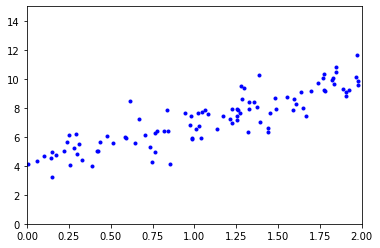

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])

compute theta_hat = (X^T * X)^-1 * X^T * y closed form solution

In [2]:
X_b = np.c_[np.ones((100,1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.07291692],
       [2.91214679]])

In [3]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.07291692],
       [9.89721051]])

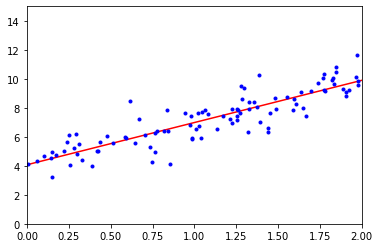

In [4]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [5]:
# Using scikit-learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.07291692]), array([[2.91214679]]))

In [6]:
lin_reg.predict(X_new)

array([[4.07291692],
       [9.89721051]])

In [7]:
# LinearRegression class is based on scipy.linalg.lstsq() function
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.07291692],
       [2.91214679]])

In [8]:
# function above computes pseudoincerse of X (specifically the Moore-Penrose inverse)
# calculation of pseudoinverse is more efficient that solving the normal equation and it handles edge cases better
# (such as when X^T * X is not invertible) - the psuedoinverse is always defined
np.linalg.pinv(X_b).dot(y)

array([[4.07291692],
       [2.91214679]])

# Gradient Descent
## Batch Gradient Descent

In [9]:
# implementation of eq 4-7 "Gradient Descent step"
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[4.07291692],
       [2.91214679]])

^ got it perfect!

## Stochastic Gradient Descent

In [10]:
# implements Stochastic Gradient Descent using a simple learning schedule
# reduce learning rate over time; similar to simulated annealing; jump out of local minima early and then converge

n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[4.08163057],
       [2.88345461]])

In [11]:
# sklearn Stochastic GD linear regression
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.06185856]), array([2.97860687]))

# Polynomial Regression

In [12]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.04152756])

In [14]:
X_poly[0]

array([-0.04152756,  0.00172454])

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.25241122]), array([[1.05408129, 0.46740846]]))

^ not bad! The model estimates y = 0.49x^2 + 0.99x + 2.02 from the original function is y = 0.5x^2 + x + 2 + noise

# Learning Curves

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right")

first look at the learning curve for fitting our quadratic data with a linear model (and linear features).

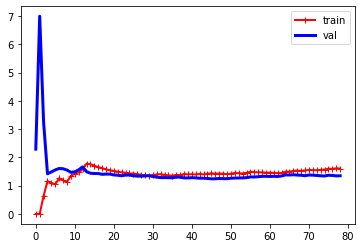

In [17]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

notice above that the red line (training error) starts with 0 RMSE for the first few instances! The model can fit just a couple points perfectly, but then it isn't able to do so anymore once more points are added. similarly, notice that the blue line (validation set RMSE) starts high and then decreases! Complementary behavior to the training set.

this learning curve is also indicative of an underfit model: both curves have reached a plateau, they are close, and the error is fairly high.

now look at learning curves of a 10th degree polynomial on the same data

(0.0, 3.0)

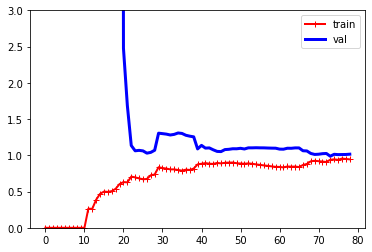

In [18]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim(top=3, bottom=0)

notice in the above plot that there's 0 training error until the 10th point! this is because its a 10th order polynomial. also notice that the model does better with the higher order polynomial! it overfits with less training points (curves further apart), but improves (curves get closer) with added training points.

# Regularized Linear Models
Reduce overfitting by regularizing (constraining the model). the fewer degress of freedom it has, the harder it will be to overfit! For linear models, regularization is typically achieved by constraining weights.

## Ridge Regression
Regularization term added to cost function; forces learning algorithm to keep model weights small. if $\alpha=0$, Ridge Regression is just linear regression. if $\alpha$ is very large, then all weights end up close to zero and the result is a flat line going through the data's mean. 

Can solve closed-form solution or use GD.

In [19]:
# closed form
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.10425821]])

In [20]:
# GD
sgd_reg = SGDRegressor(penalty="l2") # penalty sets the type of regression to use. specifying l2 norm is ridge
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.07823034])

## Lasso Regression
"Least Absolute Shrinkage and Selection Operator Regression." Similar to Ridge Regression, except that it uses the $l_1$ norm of the weight vector instead of half of the square of the $l_2$ norm.

In [21]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.05530118])

In [22]:
# alternative method
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.09141595])

note that the above two methods are technically the same but get different results! First method gets the same exact number every time, but the "alternative" differs a bit in the decimal value (even in 2nd digit).

## Elastic Net
A simple mix between Ridge and Lasso

In [23]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.05492753])

## Early Stopping

In [24]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# prepare data
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # continues where it left off! (warm_start = True)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    print(val_error)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

19.024110856561062
17.21780566691837
15.51552634064861
13.83341845910058
12.582386922556699
11.307485109383432
10.230494172556694
9.32760584867856
8.514140123117707
7.571624261874265
7.147305957682417
6.48580782756858
6.447908682806582
5.445084323747181
5.827536289410597
4.714382422142389
5.616974849463779
5.305159393901751
5.8438182731504416
5.141937945951159
7.167744633160929
6.6420911063250525
7.761247910479677
14.755195116179985
13.004863176257382
13.54638609385882
25.316371532107134
46.65264001508621
33.436079491993304
78.69215962470818
115.66712758342462
96.65169328375806
202.84477165144855
221.02871534105333
665.3309473714319
353.8239122994149
1786.8228174680164
729.3983173764801
2758.7321257860135
1857.1916591152149
8232.793418849196
3449.6851831301856
12674.725651373543
14817.113404140508
15254.134376902806
45942.915443146725
25531.10091442455
76816.81228182596
60256.1984693753
134986.17995917914
234038.55778521052
303580.6527613902
277675.92896535445
948833.6900285592
467304.

4.555286282535696e+20
1.1500688412606334e+21
2.225877122379349e+20
1.3275692003104659e+21
2.4061077493442622e+20
1.895938173277643e+21
3.6096969838771916e+20
1.6021855188390846e+21
4.876466050857498e+20
1.3284521162455478e+21
6.21053478078898e+20
4.1842519617077255e+20
5.327775822559291e+20
8.6779807333457e+20
2.5675895358113405e+20
1.1667536164492784e+21
5.947083032254469e+20
3.875106430588873e+20
5.98852565053366e+20
4.994865089769129e+20
1.364275490528715e+21
5.1900839355354985e+20
1.1614101015051821e+21
2.166737377293566e+20
1.3608007543047182e+21
6.035182197471887e+20
4.2418087301434055e+20
3.3487324213987895e+20
1.2188643988838875e+21
2.5002989191252515e+20
8.983118410065176e+20
3.886709908051838e+20
1.649927530646878e+21
5.295121879667427e+20
1.338363315057801e+21
6.252924170674168e+20
4.062752308197772e+20
8.036316545765354e+20
2.632821251330096e+20
1.373497552059173e+21
1.461159509224815e+20
1.6050024450363472e+21
1.4649430725733846e+20
2.136472501337668e+21
3.367801380732882e

2.040678551093533e+20
6.539635892163544e+20
4.098386769369323e+20
5.5836069367111516e+20
7.82395583065813e+20
3.269387337515772e+20
5.961323047110343e+20
9.766618370604003e+20
7.779704421505594e+20
8.015246262735866e+20
9.404179564453733e+20
2.1279382019764368e+20
5.974901916008976e+20
3.7482113211893953e+20
1.2362352565202922e+21
6.616373423298233e+20
1.051556289232585e+21
6.653751506938243e+20
3.722611703484744e+20
5.300499116020193e+20
5.024232251126558e+20
1.09183228382273e+21
7.332421610510753e+20
2.96934319367852e+20
5.919175041952737e+20
4.390699816534269e+20
1.1124774910784163e+21
2.1200921548328436e+20
1.2156248346939176e+21
6.653401908089506e+20
1.1476026876285123e+21
6.024218006872131e+20
1.1842341758660735e+21
5.937066998558201e+20
4.280589003959512e+20
6.319413191241035e+20
3.694415530009811e+20
5.846517740490995e+20
4.1262884769277844e+20
5.648804267066769e+20
5.1053584119619754e+20
1.3459835679739662e+21
6.010393393840441e+20
1.1193365288507639e+21
2.1387622823560793e+20

# Logistic Regression
Assigning probabilities to regression-based classification

## Decision Boundaries
Example using iris data

In [25]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [26]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int) # 1 if iris virginica, else 0

In [27]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

based on training data and model created above, predict probabilities given a range of petal widths

Text(0, 0.5, 'Probability')

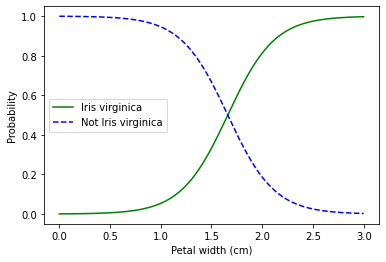

In [28]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
plt.legend(loc="center left")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")

In [29]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## Softmax Regression
(I assume because it's called softmax because you don't need over 50% odds to classify - you just need to have the biggest probability)

In [31]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [32]:
softmax_reg.predict([[5, 2]])

array([2])

In [35]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

Predicts class 2 with probability of 94%

Practical explanation of cross entropy (loss function for softmax regression)
https://towardsdatascience.com/cross-entropy-for-dummies-5189303c7735